# Classifying newswires with tf.keras, tf.data, and eager execution.

In this lab, you'll learn how to classify newswires from the [Reuters dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters) into categories. This tutorial was inspired by [this one](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.6-classifying-newswires.ipynb). This notebook is similar to previous one. The principal difference is here, we will explore a multiclass text classification problem.


In [1]:
!date
!hostname
!pip install --ignore-installed --upgrade tensorflow==1.8.0
import tensorflow as tf

# Enable eager execution
tf.enable_eager_execution()

import numpy as np

Thu May 17 23:02:22 UTC 2018
smallDLVM1
  Using cached https://files.pythonhosted.org/packages/6d/dc/464f59597a5a8282585238e6e3a7bb3770c3c1f1dc8ee72bd5be257178ec/tensorflow-1.8.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/59/a6/0ae6092b7542cfedba6b2a1c9b8dceaf278238c39484f3ba03b03f07803c/tensorboard-1.8.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/67/4b/141a581104b1f6397bfa78ac9d43d8ad29a7ca43ea90a2d863fe3056e86a/six-1.11.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b2/91/cc9805f1ff7b49f620136b3a7ca26f6a1be2ed424606804b0fbcf499f712/astor-0.6.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5b/c3/9b947e301e19bea75dc8c1fd3710eed5d2b31aa13ae13d5e38e891f784cc/protobuf-3.5.2.post1-cp35-cp35m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/2c/ff/f118147fd7a8d2d441d15e1cb7fefb2c1981586e24ef3a7d8a742535b085/grpcio-1.12.0-cp35-cp35m

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



## A first look at the dataset

### Step 1) Downloading the dataset

The dataset consists of a set of short [newswires](https://www.google.com/search?q=what+is+a+newswire) and their corresponding topics as published by Reuters in 1986.

In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.reuters.load_data(num_words=10000)

### Step 2) Exploring the dataset 

There are around 46 different topics. The set is divided into 8982 training examples and 2246 test examples. Each training example is a list of words represented as integers similar to the IMDB dataset, and the labels are integers up to 46.

In [3]:
print(train_data[0])
print(train_labels[0])
print(len(train_data))
print(len(test_data))

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3
8982
2246


### Converting the integers to words

We can get the dictionary from `tf.keras.datasets.reuters.get_word_index` which hashes the words to their corresponding integers. Let's try and convert a newswire from integers back into it's original text by first reversing this dictionary and then iterating over a newswire and converting the integers to strings.

In [4]:
# Dictionary that hashes words to their integer
word_to_integer = tf.keras.datasets.reuters.get_word_index()

In [5]:
print(list(word_to_integer.keys())[0:10])

integer_to_word = dict([(value, key) for (key, value) in word_to_integer.items()])

# Demonstrate how to find the word from an integer
print(integer_to_word[1])
print(integer_to_word[2])

import random

random_index = random.randint(0, 100)
# We need to subtract 3 from the indices because 0 is "padding", 1 is "start of sequence", and 2 is "unknown"
decoded_newswire = ' '.join([integer_to_word.get(i - 3, 'UNK') for i in train_data[random_index]])
print(decoded_newswire)
print(train_labels[random_index])

['cms', 'linares', 'rule', 'lara', 'erste', 'raw', 'slumps', 'straddle', 'human', 'dogged']
the
of
UNK the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely UNK borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley senior associate director of gao also said that a preliminary analysis of proposed changes in UNK financial eligibility standards indicated as many as one half of UNK borrowers who received new loans from the agency in 1986 would be UNK under the proposed system the agency has proposed evaluating UNK credit using a variety of financial ratios instead of relying solely on UNK ability senate agriculture committee chairman patrick leahy d vt UNK the proposed eligibility changes telling UNK administrator UNK clark at a hearing that they would mark a dra

### Step 3) Format the data
As before, we are going to multi-hot encode our newswire which is an array of integers into a 10,000 dimensional vector. We will place 1's in the indices of word-integers that occur in the newswire, and 0's for everything else.

In [6]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results


train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

print(train_data.shape)
print(train_data[0])

(8982, 10000)
[0. 1. 1. ... 0. 0. 0.]


### Step 4) Format the labels

We will also use [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to one hot encode our labels.

In [7]:
LABEL_DIMENSIONS = 46

print(train_labels[0]) # Before
train_labels  = tf.keras.utils.to_categorical(train_labels, LABEL_DIMENSIONS)
print(train_labels[0]) # After

test_labels = tf.keras.utils.to_categorical(test_labels, LABEL_DIMENSIONS)

# Needed later
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Step 5) Create the model

Our model is similar to the previous notebook, modified to work for a multiclass classification problem.

In [8]:
### Create a model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(10000,)))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(LABEL_DIMENSIONS, activation=tf.nn.softmax))

optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


### Step 6) Validation set

As before, we want to test our model on data it hasn't seen before, but before we get our final test accuracy. Here, we'll create a validation set.

In [9]:
VAL_SIZE = 1000

val_data = train_data[:VAL_SIZE]
partial_train_data = train_data[VAL_SIZE:]


val_labels = train_labels[:VAL_SIZE]
partial_train_labels = train_labels[VAL_SIZE:]

### Step 7) Create a tf.data Dataset

In [10]:
BATCH_SIZE = 512
TRAINING_SIZE = partial_train_labels.shape[0]

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.shuffle(TRAINING_SIZE).batch(BATCH_SIZE)

### Step 8) Training your model
Please be patient as this step may take a while.

In [11]:
EPOCHS = 20

# Store list of metric values for plotting later
tr_loss_list = []
tr_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(EPOCHS):
  for newswires, labels in training_set:
    # Calculate training loss and accuracy
    tr_loss, tr_accuracy = model.train_on_batch(newswires, labels)
  
  # Calculate validation loss and accuracy
  val_loss, val_accuracy = model.evaluate(val_data, val_labels)

  # Add to the lists
  tr_loss_list.append(tr_loss)
  tr_accuracy_list.append(tr_accuracy)
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)
  
  print(('Epoch #%d\t Training Loss: %.2f\tTraining Accuracy: %.2f\t'
         'Validation Loss: %.2f\tValidation Accuracy: %.2f')
         % (epoch + 1, tr_loss, tr_accuracy,
         val_loss, val_accuracy))

1000/1000 [==============================] - 0s 118us/step
Epoch #1	 Training Loss: 3.81	Training Accuracy: 0.03	Validation Loss: 3.81	Validation Accuracy: 0.03
1000/1000 [==============================] - 0s 116us/step
Epoch #2	 Training Loss: 3.77	Training Accuracy: 0.10	Validation Loss: 3.77	Validation Accuracy: 0.15
1000/1000 [==============================] - 0s 117us/step
Epoch #3	 Training Loss: 3.67	Training Accuracy: 0.30	Validation Loss: 3.66	Validation Accuracy: 0.31
1000/1000 [==============================] - 0s 116us/step
Epoch #4	 Training Loss: 3.42	Training Accuracy: 0.41	Validation Loss: 3.35	Validation Accuracy: 0.47
1000/1000 [==============================] - 0s 122us/step
Epoch #5	 Training Loss: 2.79	Training Accuracy: 0.51	Validation Loss: 2.74	Validation Accuracy: 0.51
1000/1000 [==============================] - 0s 122us/step
Epoch #6	 Training Loss: 2.17	Training Accuracy: 0.54	Validation Loss: 2.16	Validation Accuracy: 0.53
1000/1000 [=======================

### Step 9) Plotting your loss and accuracy
We are going to use `matplotlib` to plot our training and validation metrics.

In [12]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# "bo" specifies "blue dot"
plt.plot(epochs, tr_loss_list, 'bo', label='Training loss')
# b specifies a "solid blue line"
plt.plot(epochs, val_loss_list, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

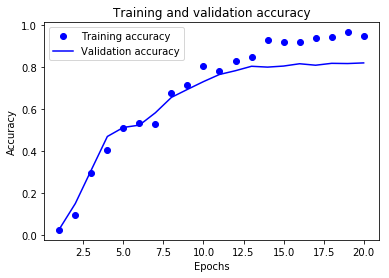

In [13]:
plt.clf()   # Clear plot

plt.plot(epochs, tr_accuracy_list, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_list, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Step 10) Testing your model
Now that we have successfully trained our model and our training accuracy has jumped over 90%, we need to test it. The test accuracy is a better evaluation metric for how our model will perform in the real world.

In [14]:
loss, accuracy = model.evaluate(test_data, test_labels)
print('Test accuracy: %.2f' % (accuracy))

2246/2246 [==============================] - 0s 127us/step
Test accuracy: 0.79
